In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, ConstantKernel, ExpSineSquared, DotProduct
from matplotlib import pyplot as plt

In [2]:
# Loading Taxi Dataset (fhv / hvfhv / yellow / green / allsum)
fhv = pd.read_csv("https://raw.githubusercontent.com/sujeongcha/TimeSeries-Transporation-and-Covid19/main/Data/Taxi_Data/full_fhv.csv")
hvfhv = pd.read_csv("https://raw.githubusercontent.com/sujeongcha/TimeSeries-Transporation-and-Covid19/main/Data/Taxi_Data/full_hvfhv.csv")
yellow = pd.read_csv("https://raw.githubusercontent.com/sujeongcha/TimeSeries-Transporation-and-Covid19/main/Data/Taxi_Data/full_yellow.csv")
green = pd.read_csv("https://raw.githubusercontent.com/sujeongcha/TimeSeries-Transporation-and-Covid19/main/Data/Taxi_Data/full_green.csv")
taxi = pd.read_csv("https://raw.githubusercontent.com/sujeongcha/TimeSeries-Transporation-and-Covid19/main/Data/Taxi_Data/full_taxi_types.csv")

# converting pickup_datetime to datetime object
for df in [fhv, hvfhv, yellow, green, taxi]:
    df.pickup_datetime = pd.to_datetime(df.pickup_datetime)
print("Checking datatype:\n")
print(taxi.info())

# groupby datetime
fhv = fhv.groupby(['pickup_datetime']).sum()
hvfhv = hvfhv.groupby(['pickup_datetime']).sum()
yellow = yellow.groupby(['pickup_datetime']).sum()
green = green.groupby(['pickup_datetime']).sum()
taxi = taxi.groupby(['pickup_datetime']).sum()
print("\nChecking groupby:\n")
print(taxi.head(5))

Checking datatype:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33923 entries, 0 to 33922
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   pickup_datetime  33923 non-null  datetime64[ns]
 1   Borough          33923 non-null  object        
 2   passenger_count  33923 non-null  int64         
 3   trip_distance    32867 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.0+ MB
None

Checking groupby:

                 passenger_count  trip_distance
pickup_datetime                                
2015-01-01                860105       6.458856
2015-01-02                728493      40.499140
2015-01-03                879888      19.506015
2015-01-04                686645      25.238159
2015-01-05                729239       6.060544


In [3]:
old = yellow.append(green).groupby(['pickup_datetime']).sum()
new = fhv.append(hvfhv).groupby(['pickup_datetime']).sum()

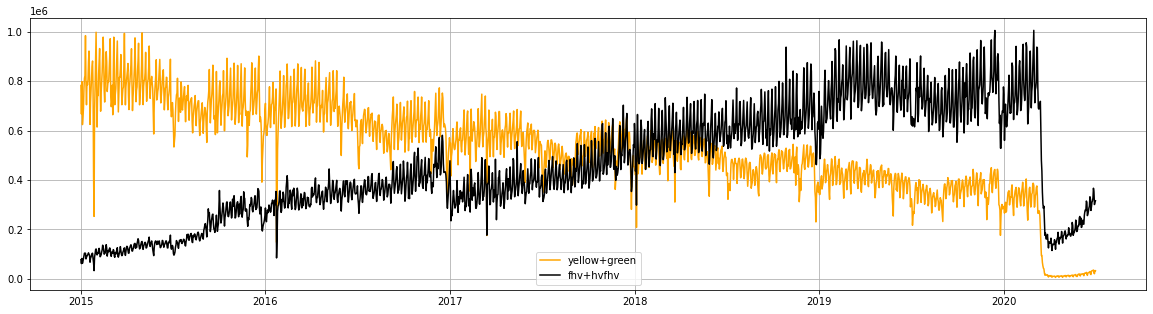

In [4]:
plt.figure(figsize=(20,5))
plt.plot(old.passenger_count, color='orange', label="yellow+green")
plt.plot(new.passenger_count, color='black', label="fhv+hvfhv")
plt.legend()
plt.grid()
plt.show()

In [5]:
# preCovid // postCovid
covidOutbreak = '2020-03-01'
old = old['passenger_count'].groupby(old.index).sum()
new = new['passenger_count'].groupby(new.index).sum()
old_preCovid = old.loc[:covidOutbreak]
new_preCovid = new.loc[:covidOutbreak]
old_postCovid = old.loc[covidOutbreak:]
new_postCovid = new.loc[covidOutbreak:]

In [6]:
# train / test
trainCutoff = '2019-12-31'
old_train = old_preCovid[:trainCutoff]
new_train = new_preCovid[:trainCutoff]
old_test = old_preCovid['2020-01-01':]
new_test = new_preCovid['2020-01-01':]

In [7]:
# normalization
scaler = StandardScaler()
scaler.fit(old_train.values.reshape(-1,1))
old_train = scaler.transform(old_train.values.reshape(-1,1))
old_test = scaler.transform(old_test.values.reshape(-1,1))

In [8]:
def plot_gp(x_pred, y_pred, sigmas, x_train, y_train, true_y=None, samples=None, ax=None, legendon=True):
    """
    Function that plots the GP mean & std on top of given points.
    x_pred: points for prediction
    y_pred: means
    sigmas: std
    x, y: given data
    true_y: 
    samples: 2D numpy array with shape (# of points, # of samples)
    """
    if samples is not None:
        ax.plot(x_pred.reshape(-1, 1), samples)
    
    ax.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0, 
                 ecolor=(0.65, 0.65, 0.65), fmt = "r-", 
                 label="pred mean")
    ax.plot(x_train, y_train, "ko", label="training set")
    if true_y is not None:
        ax.plot(x_pred, true_y, "b-", label="ground truth")
    if legendon: ax.legend()

In [18]:
traintime = np.arange(len(old_train))
predtime = np.arange(len(old_preCovid))
true_y = np.append(old_train, old_test)

kernel = RBF() + ExpSineSquared(periodicity=7)*DotProduct() + ConstantKernel(constant_value=1)
gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
gp.fit(traintime.reshape(-1,1), old_train.reshape(-1,1))
mus, sigmas = gp.predict(predtime.reshape(-1,1), return_std=True)

C:\Users\sujeong\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


mse = 0.03301917490921567


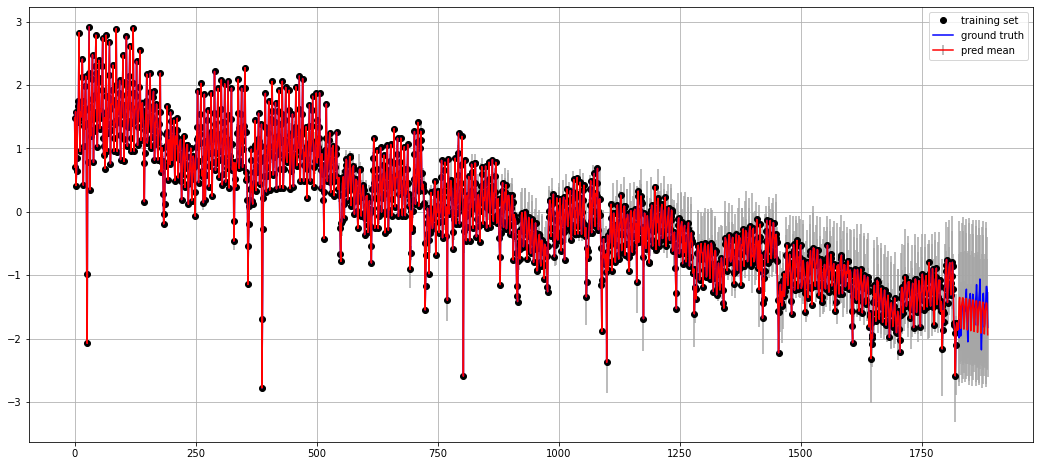

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(18,8))
plot_gp(predtime, mus, sigmas, traintime, old_train, true_y, ax=ax)
plt.grid()
print("mse = {0}".format((mean_squared_error(mus[len(old_train):], true_y[len(old_train):]))))

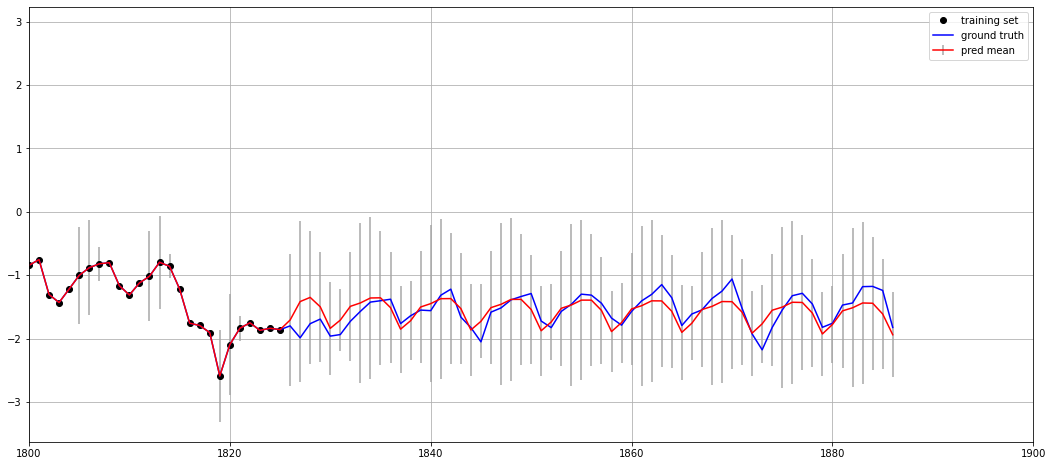

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(18,8))
plot_gp(predtime, mus, sigmas, traintime, old_train, true_y, ax=ax)
plt.xlim(1800, 1900)
plt.grid()

In [21]:
print("mse = {0}".format((mean_squared_error(mus[-len(old_test):], true_y[-len(old_test):]))))

mse = 0.03301917490921567
